# 8. PV_DNN_forecasting

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font',family='Malgun Gothic')
plt.rcParams['axes.unicode_minus']=False

# 1. 데이터 읽기

In [3]:
df = pd.read_csv('./datasets/한국남부발전(주)_신인천소내 태양광발전실적_기상_2021_1H_.csv', encoding='cp949')
df

,일시,기온(°C),일사(MJ/m2),전운량(10분위),강수량(mm),적설(cm),PV
0,2021-01-01 00:00:00,-7.5,0.0,0.0,0.0,0.0,0.0
1,2021-01-01 01:00:00,-7.8,0.0,0.0,0.0,0.0,0.0
2,2021-01-01 02:00:00,-7.8,0.0,2.0,0.0,0.0,0.0
3,2021-01-01 03:00:00,-8.0,0.0,0.0,0.0,0.0,0.0
4,2021-01-01 04:00:00,-7.9,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
8755,2021-12-31 19:00:00,-5.4,0.0,0.0,0.0,0.0,0.0
8756,2021-12-31 20:00:00,-5.8,0.0,0.0,0.0,0.0,0.0
8757,2021-12-31 21:00:00,-6.7,0.0,0.0,0.0,0.0,0.0
8758,2021-12-31 22:00:00,-7.2,0.0,0.0,0.0,0.0,0.0


In [4]:
df.index = pd.to_datetime(df['일시'])
df = df.drop(['일시'], axis=1)
df

,기온(°C),일사(MJ/m2),전운량(10분위),강수량(mm),적설(cm),PV
일시,,,,,,
2021-01-01 00:00:00,-7.5,0.0,0.0,0.0,0.0,0.0
2021-01-01 01:00:00,-7.8,0.0,0.0,0.0,0.0,0.0
2021-01-01 02:00:00,-7.8,0.0,2.0,0.0,0.0,0.0
2021-01-01 03:00:00,-8.0,0.0,0.0,0.0,0.0,0.0
2021-01-01 04:00:00,-7.9,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
2021-12-31 19:00:00,-5.4,0.0,0.0,0.0,0.0,0.0
2021-12-31 20:00:00,-5.8,0.0,0.0,0.0,0.0,0.0
2021-12-31 21:00:00,-6.7,0.0,0.0,0.0,0.0,0.0


# 2. 데이터 준비

## 1) 학습용/테스트용 데이터 분할

In [5]:
# 학습용
train_set = df.loc['2021-01-01 00:00:00':'2021-09-30 23:00:00']
# 테스트용
test_set = df.loc['2021-10-01 00:00:00':'2021-10-31 23:00:00']

In [6]:
train_set.head()

,기온(°C),일사(MJ/m2),전운량(10분위),강수량(mm),적설(cm),PV
일시,,,,,,
2021-01-01 00:00:00,-7.5,0.0,0.0,0.0,0.0,0.0
2021-01-01 01:00:00,-7.8,0.0,0.0,0.0,0.0,0.0
2021-01-01 02:00:00,-7.8,0.0,2.0,0.0,0.0,0.0
2021-01-01 03:00:00,-8.0,0.0,0.0,0.0,0.0,0.0
2021-01-01 04:00:00,-7.9,0.0,0.0,0.0,0.0,0.0


In [7]:
test_set.head()

,기온(°C),일사(MJ/m2),전운량(10분위),강수량(mm),적설(cm),PV
일시,,,,,,
2021-10-01 00:00:00,20.6,0.0,0.0,0.0,0.0,0.0
2021-10-01 01:00:00,20.3,0.0,0.0,0.0,0.0,0.0
2021-10-01 02:00:00,19.7,0.0,0.0,0.0,0.0,0.0
2021-10-01 03:00:00,19.5,0.0,0.0,0.0,0.0,0.0
2021-10-01 04:00:00,19.2,0.0,0.0,0.0,0.0,0.0


## 2) 데이터 정규화

In [8]:
# 평균, 표준편차
train_stats = train_set.describe().transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
기온(°C),6552.0,14.984829,10.682793,-17.5,7.375,17.300,23.600,34.000
일사(MJ/m2),6552.0,0.654736,0.935474,0.0,0.000,0.055,1.150,3.580
전운량(10분위),6552.0,5.340507,3.894411,0.0,1.000,6.000,9.000,10.000
강수량(mm),6552.0,0.145543,1.098204,0.0,0.000,0.000,0.000,37.400
적설(cm),6552.0,0.038233,0.287073,0.0,0.000,0.000,0.000,4.600
PV,6552.0,30.563489,46.134905,0.0,0.000,0.506,51.212,188.841


In [9]:
# 정규화 : Z-변환
def norm(x):
    return (x-train_stats['mean']) / train_stats['std']

# 학습용 데이터 정규화
normed_train_data = norm(train_set)
# 테스트용 데이터 정규화
normed_test_data = norm(test_set)

In [10]:
normed_train_data.head()

,기온(°C),일사(MJ/m2),전운량(10분위),강수량(mm),적설(cm),PV
일시,,,,,,
2021-01-01 00:00:00,-2.104771,-0.699898,-1.371326,-0.132528,-0.133181,-0.662481
2021-01-01 01:00:00,-2.132853,-0.699898,-1.371326,-0.132528,-0.133181,-0.662481
2021-01-01 02:00:00,-2.132853,-0.699898,-0.857769,-0.132528,-0.133181,-0.662481
2021-01-01 03:00:00,-2.151575,-0.699898,-1.371326,-0.132528,-0.133181,-0.662481
2021-01-01 04:00:00,-2.142214,-0.699898,-1.371326,-0.132528,-0.133181,-0.662481


In [11]:
normed_test_data.head()

,기온(°C),일사(MJ/m2),전운량(10분위),강수량(mm),적설(cm),PV
일시,,,,,,
2021-10-01 00:00:00,0.525628,-0.699898,-1.371326,-0.132528,-0.133181,-0.662481
2021-10-01 01:00:00,0.497545,-0.699898,-1.371326,-0.132528,-0.133181,-0.662481
2021-10-01 02:00:00,0.441380,-0.699898,-1.371326,-0.132528,-0.133181,-0.662481
2021-10-01 03:00:00,0.422658,-0.699898,-1.371326,-0.132528,-0.133181,-0.662481
2021-10-01 04:00:00,0.394576,-0.699898,-1.371326,-0.132528,-0.133181,-0.662481


## 3) 입출력 데이터 만들기

In [12]:
# 학습용 데이터 값 추출
normed_train_data = normed_train_data.values
# 테스트용 데이터 값 추출
normed_test_data = normed_test_data.values

In [13]:
normed_train_data

array([[-2.10477056, -0.69989779, -1.37132591, -0.13252849, -0.1331809 ,
        -0.66248082],
       [-2.1328531 , -0.69989779, -1.37132591, -0.13252849, -0.1331809 ,
        -0.66248082],
       [-2.1328531 , -0.69989779, -0.85776943, -0.13252849, -0.1331809 ,
        -0.66248082],
       ...,
       [ 0.59115352, -0.69989779, -1.37132591, -0.13252849, -0.1331809 ,
        -0.66248082],
       [ 0.57243183, -0.69989779, -1.37132591, -0.13252849, -0.1331809 ,
        -0.66248082],
       [ 0.54434928, -0.69989779, -1.37132591, -0.13252849, -0.1331809 ,
        -0.66248082]])

In [14]:
# 시간 지연을 갖는 입출력 데이터 만들기
def build_dataset(ts):
    dataX = []
    dataY = []
    for i in range(0, len(ts) - 1):
        _x = ts[i,:]
        _y = ts[i+1, -1]
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

# 학습용
normed_trainX, normed_trainY = build_dataset(normed_train_data)
# 테스트용
normed_testX, normed_testY = build_dataset(normed_test_data)

In [15]:
normed_trainX

array([[-2.10477056, -0.69989779, -1.37132591, -0.13252849, -0.1331809 ,
        -0.66248082],
       [-2.1328531 , -0.69989779, -1.37132591, -0.13252849, -0.1331809 ,
        -0.66248082],
       [-2.1328531 , -0.69989779, -0.85776943, -0.13252849, -0.1331809 ,
        -0.66248082],
       ...,
       [ 0.63795776, -0.69989779, -1.37132591, -0.13252849, -0.1331809 ,
        -0.66248082],
       [ 0.59115352, -0.69989779, -1.37132591, -0.13252849, -0.1331809 ,
        -0.66248082],
       [ 0.57243183, -0.69989779, -1.37132591, -0.13252849, -0.1331809 ,
        -0.66248082]])

In [16]:
normed_trainY

array([-0.66248082, -0.66248082, -0.66248082, ..., -0.66248082,
       -0.66248082, -0.66248082])

# 3. 모델 설계

## 1) DNN 모델 설계

In [17]:
len(normed_trainX[0])

6

In [18]:
# 모델 구조
model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=[len(normed_trainX[0])]), # 입력층
        tf.keras.layers.Dense(64, activation='relu'),                   # 은닉층 1
        tf.keras.layers.Dense(32, activation='relu'),                   # 은닉층 2
        tf.keras.layers.Dense(1)                                            # 출력층
])

In [19]:
# 모델 컴파일
model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=['mean_absolute_error','mean_squared_error'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               896       
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________


## 2) 모델 학습

In [21]:
EPOCHS = 30

history = model.fit(normed_trainX, normed_trainY, epochs=EPOCHS, validation_split = 0.2,)
11

Epoch 1/30
164/164 [==============================] - 1s 3ms/step - loss: 0.1863 - mean_absolute_error: 0.2736 - mean_squared_error: 0.1863 - val_loss: 0.1304 - val_mean_absolute_error: 0.2783 - val_mean_squared_error: 0.1304
Epoch 2/30
164/164 [==============================] - 0s 2ms/step - loss: 0.1581 - mean_absolute_error: 0.2509 - mean_squared_error: 0.1581 - val_loss: 0.1352 - val_mean_absolute_error: 0.2327 - val_mean_squared_error: 0.1352
Epoch 3/30
164/164 [==============================] - 0s 2ms/step - loss: 0.1563 - mean_absolute_error: 0.2463 - mean_squared_error: 0.1563 - val_loss: 0.1353 - val_mean_absolute_error: 0.2193 - val_mean_squared_error: 0.1353
Epoch 4/30
164/164 [==============================] - 0s 2ms/step - loss: 0.1560 - mean_absolute_error: 0.2474 - mean_squared_error: 0.1560 - val_loss: 0.1142 - val_mean_absolute_error: 0.2123 - val_mean_squared_error: 0.1142
Epoch 5/30
164/164 [==============================] - 0s 2ms/step - loss: 0.1536 - mean_absolute

11

## 3) 학습 과정 시각화

In [22]:
# 학습 과정 결과를 DataFrame으로 만들기
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
0,0.186346,0.273646,0.186346,0.130447,0.278307,0.130447,0
1,0.158099,0.250908,0.158099,0.135156,0.232747,0.135156,1
2,0.156265,0.246290,0.156265,0.135313,0.219283,0.135313,2
3,0.155989,0.247374,0.155989,0.114157,0.212272,0.114157,3
4,0.153570,0.241733,0.153570,0.128327,0.223355,0.128327,4
5,0.159067,0.254450,0.159067,0.116342,0.207084,0.116342,5
6,0.153247,0.241133,0.153247,0.116745,0.205703,0.116745,6
7,0.152792,0.243530,0.152792,0.130836,0.221492,0.130836,7
8,0.152982,0.242684,0.152982,0.114248,0.208256,0.114248,8
9,0.150096,0.238450,0.150096,0.123555,0.224210,0.123555,9


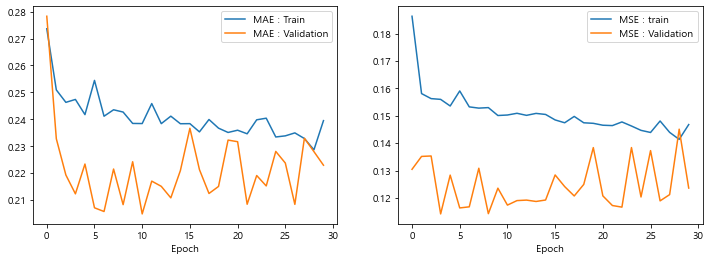

In [23]:
# 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(hist['epoch'], hist['mean_absolute_error'], label='MAE : Train')
plt.plot(hist['epoch'], hist['val_mean_absolute_error'], label='MAE : Validation')
plt.xlabel('Epoch')
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist['epoch'], hist['mean_squared_error'], label='MSE : train')
plt.plot(hist['epoch'], hist['val_mean_squared_error'], label='MSE : Validation')
plt.xlabel('Epoch')
plt.legend()

# 4. 예측 수행

## 1) 예측 수행

In [24]:
# 예측 수행
normed_test_predictions = model.predict(normed_testX).flatten()
normed_test_predictions

24/24 [==============================] - 0s 956us/step


array([-0.67553246, -0.67490494, -0.6736953 , -0.6733209 , -0.6728225 ,
       -0.67201996, -0.7187127 , -0.7020072 , -0.24191678,  0.38692778,
        0.82058537,  1.3229994 ,  1.6279355 ,  1.6681406 ,  1.5262854 ,
        1.1785324 ,  0.6650622 ,  0.48694974, -0.36515513, -0.6779827 ,
       -0.68711257, -0.7225205 , -0.7449806 , -0.735695  , -0.7216455 ,
       -0.7034409 , -0.6916323 , -0.7184495 , -0.6869161 , -0.6768707 ,
       -0.6724024 , -0.7064233 , -0.46494588, -0.04313757,  0.27049816,
        1.2558222 ,  1.5022918 ,  1.7728457 ,  1.6472892 ,  1.276447  ,
        0.74152386,  0.5715128 , -0.3493345 , -0.6781883 , -0.677389  ,
       -0.6763691 , -0.67615986, -0.67595077, -0.67553246, -0.67511404,
       -0.67449594, -0.71351373, -0.67677915, -0.67249024, -0.67215776,
       -0.65239227, -0.28793415,  0.56761175,  0.6748562 ,  1.291112  ,
        1.6167817 ,  1.7529049 ,  1.4471862 ,  1.2463354 ,  0.57514286,
       -0.00288244, -0.30422297, -0.71034133, -0.71055555, -0.68

## 2) 비정규화

In [25]:
# 비정규화
def denorm(y):
    return y*train_stats['std'][-1] + train_stats['mean'][-1]

testY = denorm(normed_testY)
testY_predictions = denorm(normed_test_predictions)

## 3) 모델 출력 비교

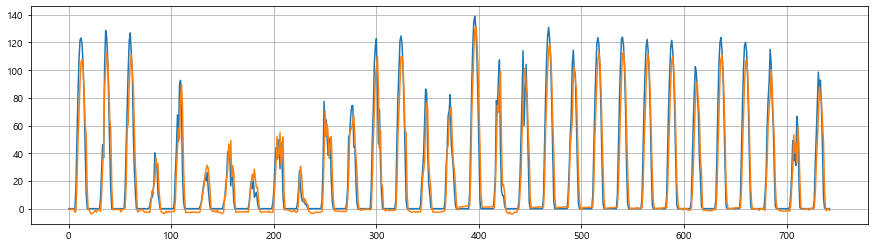

In [26]:
# 출력 비교
plt.figure(figsize=(15,4))
plt.plot(testY)
plt.plot(testY_predictions)
plt.grid()
plt.show()

# 5. 성능 평가

In [27]:
# 성능 평가
MAE = np.mean( np.abs(testY-testY_predictions))
MSE = np.mean((testY-testY_predictions)**2)
RMSE = np.sqrt(MSE)
print('MAE : ' + '{:.2f}'.format(MAE))
print('MSE : ' + '{:.2f}'.format(MSE))
print('RMSE : ' + '{:.2f}'.format(RMSE))

MAE : 8.64
MSE : 191.13
RMSE : 13.83


In [28]:
# 발전소 발전용량
capacity = 200

# 발전용량 절대오차
absolute_error = np.abs(testY - testY_predictions)

# 발전용량으로 정규화
absolute_error /= capacity

# 발전용량의 10% 이상 발전한 데이터 인덱스 추출
target_idx = testY >= capacity*0.1

# NMAE(%)
nmae = 100 * np.mean(absolute_error[target_idx])
print('NMAE : ' + '{:.2f}'.format(nmae))

NMAE : 9.27
